# Bank customer churn modeling

## Question:

 Given a Bank customer, can we build a classifier which can determine whether they will leave or not?

---



## Answer:

Below is all my process to arrive a solution to classify customer if he/she has a chances to churn or not.

First, I analysed the data and prepared dataset to be used to models. Afterwards I run the most know models to classify. Basic models and some embleds. And to finish I build a simple neural network to compare results.

My conclusion and my answers about this test are in the end of document.

## 1. Load data

I used this code to mount a storage to load the dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


I created a folder in path `My\ Drive/career/EcoVadis/career/EcoVadis/churn/data/Churn_Modelling.csv`

With the command below, I checked if path is accessible.

In [0]:
!ls -all -h /content/gdrive/My\ Drive/career/EcoVadis/churn/data/Churn_Modelling.csv

-rw------- 1 root root 669K Jun 13 15:42 '/content/gdrive/My Drive/career/EcoVadis/churn/data/Churn_Modelling.csv'


Everything is ok. So it is possible to load the dataset

In [0]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/gdrive/My Drive/career/EcoVadis/churn/data/Churn_Modelling.csv')

## 2. Some observations

First is necessary to a exploratory analysis to have idea about the dataset and data quality.

Let's see the first five lines to see types and some data.

In [0]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Let's see a resume about data. With this, we can have some general informations as customes age mean, min and max salaries, among other.

In [0]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [0]:
df.shape

(10000, 14)

## 3. Verifications

Now, let's see if exists null data.

In [0]:
total_nas = df.isna().values.sum()
total_nas

0

Ok. The are not null data, so let's verify if exists duplicates rows.

In [0]:
duplicateds = df[df.duplicated()]
duplicateds

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


Also there aren't dupliceted data... This is a very good dataset!!!

Let's see if it is a balanced dataset.

In [0]:
df.groupby(["Exited"]).size().reset_index(name="counts")

,Exited,counts
0,0,7963
1,1,2037


We need a dataset with the same amount of customers who continue in bank and customers who exited, else this analysis will has bias and it will tend to classify more customers as a continue profile.

But we know (and we hope) that there are more customers who still stay in bank than customers who exited. This data set represents exactly this scenario. For this we have to do something about it.

There are some ways. We can use the unbased dataset and try penalized models. Some versions of algorithms like SVN allows it. 

I would rather try to balance the dataset. For this I can subtract data and use same quantities or created new samples of data that there are less. 

For test I prefer use de same quantities. In a real case is better to test all possibilities.

In [0]:
all_exited = df[df["Exited"] == 1]
all_exited.shape

(2037, 14)

In [0]:
all_current = df[df["Exited"] == 0]
all_current.shape

(7963, 14)

In [0]:
all_current = all_current.sample(2037)
all_current.shape

(2037, 14)

In [0]:
frames = [all_exited, all_current]
dataset = pd.concat(frames)
dataset.shape

(4074, 14)

In [0]:
dataset = dataset.sort_values(by=['RowNumber'])
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1


Now we have same quantities of data.

Let's see the correlations amount variables.

In [0]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(14, 14))
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,-0.211014,0.314649,-0.0643841,0.041276,-0.0821116,-0.246714,-0.0927198,-0.148191,-0.272108,-0.123913,-0.199799,-0.0612003,0.0329053
1,-0.211014,1,0.267418,0.203292,-0.0655911,-0.276025,-0.0687497,0.14115,0.448604,0.00973028,0.364683,0.219198,-0.179906,0.0358449
2,0.314649,0.267418,1,-0.220827,0.0475283,-0.367797,-0.0170258,-0.45595,0.041402,-0.53648,0.110986,0.13967,0.072958,-0.112034
3,-0.0643841,0.203292,-0.220827,1,0.298544,0.111539,-0.140679,0.402256,0.444575,-0.0129669,-0.119652,0.471061,-0.421886,0.311617
4,0.041276,-0.0655911,0.0475283,0.298544,1,0.608096,-0.0709819,0.485453,0.207039,0.045215,-0.565345,0.62365,-0.168425,0.504373
5,-0.0821116,-0.276025,-0.367797,0.111539,0.608096,1,-0.137431,0.747805,0.161254,0.173525,-0.554304,0.472956,0.274505,0.318667
6,-0.246714,-0.0687497,-0.0170258,-0.140679,-0.0709819,-0.137431,1,-0.0803499,-0.123056,0.0301802,0.065418,-0.109529,-0.0417482,0.174139
7,-0.0927198,0.14115,-0.45595,0.402256,0.485453,0.747805,-0.0803499,1,0.586567,0.431831,-0.178626,0.405889,-0.119448,0.40316
8,-0.148191,0.448604,0.041402,0.444575,0.207039,0.161254,-0.123056,0.586567,1,0.156734,0.331005,0.525722,-0.209516,0.492889
9,-0.272108,0.00973028,-0.53648,-0.0129669,0.045215,0.173525,0.0301802,0.431831,0.156734,1,-0.0451252,0.0749347,-0.43024,0.0251122


We verified that doesn't exist a correlation between two variable height enough for remove one of theirs.

Dataset is ok. 

## 4. Some Transformations

Now, let's separate only columns that have influence in classification. 

We know that RowNumber, CustomerId and	Surname are columns that shoudn't influence in solve classification, so we will drop this columns.

In [0]:
dataset = dataset[dataset.columns[3:]]
dataset.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1


There are some categorical columns. Let's change its values for numbers.

Let's start with column *Geography*

In [0]:
geography_labels, geography_uniques = pd.factorize(dataset["Geography"])
geography_labels

array([0, 0, 1, ..., 0, 0, 2])

In [0]:
geography_uniques

Index(['France', 'Spain', 'Germany'], dtype='object')

In [0]:
dataset.drop(columns=['Geography'])
dataset['Geography'] = geography_labels
dataset.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,Female,42,2,0.00,1,1,1,101348.88,1
2,502,0,Female,42,8,159660.80,3,1,0,113931.57,1
5,645,1,Male,44,8,113755.78,2,1,0,149756.71,1
6,822,0,Male,50,7,0.00,2,1,1,10062.80,0
7,376,2,Female,29,4,115046.74,4,1,0,119346.88,1


Let's do the same with *Gender*

In [0]:
gender_labels, gender_uniques = pd.factorize(dataset["Gender"])
gender_labels

array([0, 0, 1, ..., 1, 0, 1])

In [0]:
gender_uniques

Index(['Female', 'Male'], dtype='object')

In [0]:
dataset.drop(columns=['Gender'])
dataset['Gender'] = gender_labels
dataset.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
5,645,1,1,44,8,113755.78,2,1,0,149756.71,1
6,822,0,1,50,7,0.00,2,1,1,10062.80,0
7,376,2,0,29,4,115046.74,4,1,0,119346.88,1


In [0]:
dataset.shape

(4074, 11)

Our dataset is finally ready to run the model.

## 5. Run models

This is a classification problem, so we will run different models to classification and choose the best.

The best model will be that to get the best accuracy and will be the less fake negatives. Why? For this problem fake negatives is worse than fake positives, because if we classify a customer who isn't thinking to exit bank and we do somenthing about it as give him a discount, for example, this isn't a problem. This customer will stay still more happy with bank. But if our model classify a customer who want to exit wrong... so the bank will be able to do nothing about it, and it will continue to lost customers.

So, let's found out a good model with the best accuracy and few fake negatives. This can be hard... so we can use other metrics like f1-score to help us to arrive a good result too.

Let's start by separating the labels from the data, and we will separe data beetwen data test and data train.

In [0]:
X = dataset.drop(['Exited'],axis=1)
y = dataset['Exited']

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Let's also leave ready our method to print the confusion matrix.

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, auc

In [0]:
def confusion_matrix_c(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_label = ["No Exited", "Exited"]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [0]:
def plot_roc_auc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## Simple models

Let's first run some traditional models to observe their result so we can decide which is the best solution. 

Each model I run with diferentes params and I used what had the best result.

### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
lr = LogisticRegression(C=1, penalty='l1', random_state=42)
lr.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred_lr = lr.predict(X_test)

In [0]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       615
           1       0.74      0.71      0.72       608

    accuracy                           0.73      1223
   macro avg       0.73      0.73      0.73      1223
weighted avg       0.73      0.73      0.73      1223



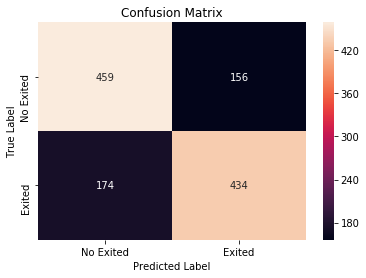

In [0]:
confusion_matrix_c(y_test, y_pred_lr)

In [0]:
lr_score_train = lr.score(X_train,y_train)
print("Train Prediction Score",lr_score_train*100)
lr_score_test = accuracy_score(y_test,y_pred_lr)
print("Test Prediction Score",lr_score_test*100)

Train Prediction Score 70.78218169063486
Test Prediction Score 73.01717089125103


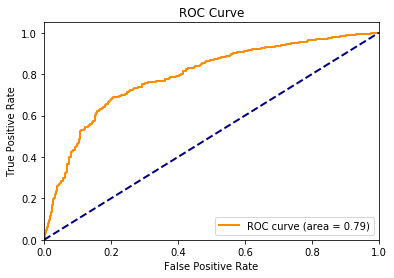

In [0]:
y_predict_probabilities = lr.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)

Logistic regression shows a prediction amount 70%.  The values of precision, recall, f1-score are similar. The curve ROC shows a bigger precision.

In general, is a medium result. The fake negatives about to have a profile to exit are hight, 174 and are bigger that fake positives.

### K-Nearest Neighbour

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
y_pred_knn = knn.predict(X_test)

In [0]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.53      0.54      0.54       605
           1       0.54      0.54      0.54       618

    accuracy                           0.54      1223
   macro avg       0.54      0.54      0.54      1223
weighted avg       0.54      0.54      0.54      1223



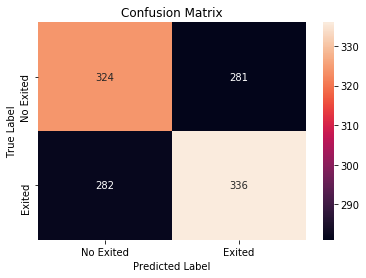

In [0]:
confusion_matrix_c(y_test, y_pred_knn)

In [0]:
knn_score_train = knn.score(X_train,y_train)
print("Train Prediction Score",knn_score_train*100)
knn_score_test = accuracy_score(y_test,y_pred_knn)
print("Test Prediction Score",knn_score_test*100)

Train Prediction Score 69.76499473868817
Test Prediction Score 53.96565821749796


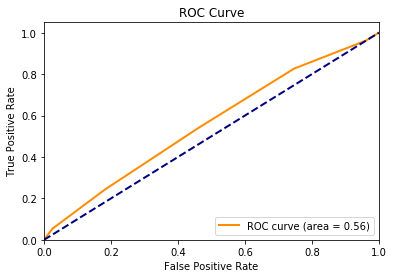

In [0]:
y_predict_probabilities = knn.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)

K-NN had a not good result... amount only 50% of precision, the bad percentages to precision, recall, f1-score, high index mistakes in confusion matrix, and a ROC curve so much close a random curve.

### Support Vector Machine

In [0]:
from sklearn.svm import SVC

In [0]:
svc = SVC(random_state = 42, probability=True)
svc.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred_svc = svc.predict(X_test)

In [0]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       614
           1       0.50      1.00      0.66       609

    accuracy                           0.50      1223
   macro avg       0.25      0.50      0.33      1223
weighted avg       0.25      0.50      0.33      1223



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


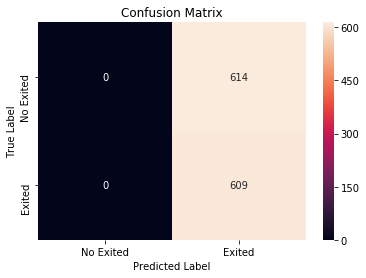

In [0]:
confusion_matrix_c(y_test, y_pred_svc)

In [0]:
svc_score_train = svc.score(X_train,y_train)
print("Train Prediction Score", svc_score_train*100)
svc_score_test = accuracy_score(y_test,y_pred_svc)
print("Test Prediction Score", svc_score_test*100)

Train Prediction Score 100.0
Test Prediction Score 49.795584627964026


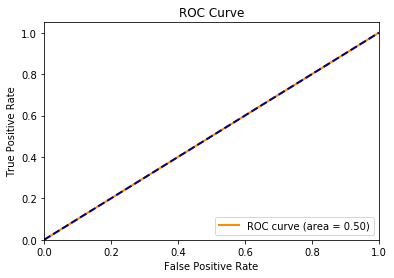

In [0]:
y_predict_probabilities = svc.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)

SVN had the worse result. It had bias. Its ROC curve shows a result so close a random curve. Definitly this model won't be used.


### Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB

In [0]:
nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
y_pred_nb = nb.predict(X_test)

In [0]:
print(classification_report(y_test,y_pred_nb))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       614
           1       0.72      0.68      0.70       609

    accuracy                           0.71      1223
   macro avg       0.71      0.71      0.71      1223
weighted avg       0.71      0.71      0.71      1223



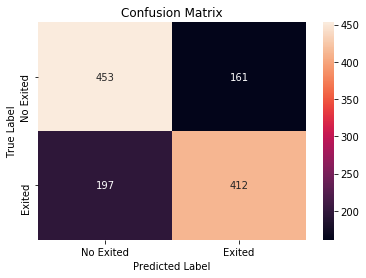

In [0]:
confusion_matrix_c(y_test, y_pred_nb)

In [0]:
nb_score_train = nb.score(X_train,y_train)
print("Train Prediction Score",nb_score_train*100)
nb_score_test = accuracy_score(y_test,y_pred_nb)
print("Test Prediction Score",nb_score_test*100)

Train Prediction Score 68.01122413188355
Test Prediction Score 70.72771872444807


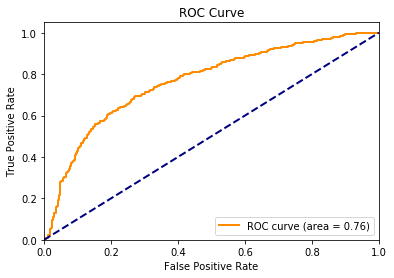

In [0]:
y_predict_probabilities = nb.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)

Naive bayer had a medium result too. A few smaller than Logistic regression. Its metrics had a similares values too.



### Decision Tree Classifier

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [0]:
param_grid={'max_depth':range(1,15,2)}
dt_g=DecisionTreeClassifier(random_state = 42)
dt_cv=GridSearchCV(dt_g,param_grid,cv=10,scoring='accuracy',n_jobs=-1)
dt_cv.fit(X_train,y_train)

print("Best parameters:",dt_cv.best_params_)
print("Accuracy :",dt_cv.best_score_)

Best parameters: {'max_depth': 5}
Accuracy : 0.7537706068046299


In [0]:
dt = DecisionTreeClassifier(max_depth=5,random_state = 42)
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [0]:
y_pred_dt = dt.predict(X_test)

In [0]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74       599
           1       0.76      0.68      0.72       624

    accuracy                           0.73      1223
   macro avg       0.73      0.73      0.73      1223
weighted avg       0.73      0.73      0.73      1223



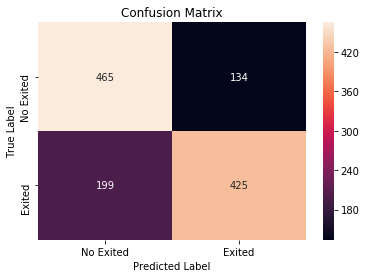

In [0]:
confusion_matrix_c(y_test, y_pred_dt)

In [0]:
dt_score_train = dt.score(X_train,y_train)
print("Train Prediction Score",dt_score_train*100)
dt_score_test = accuracy_score(y_test,y_pred_dt)
print("Test Prediction Score",dt_score_test*100)

Train Prediction Score 76.70992634163451
Test Prediction Score 72.77187244480785


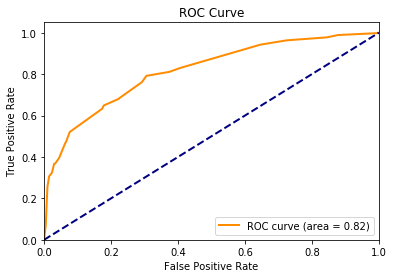

In [0]:
y_predict_probabilities = dt.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)

Of traditionals models the decision tree had the best result, amount 75%.


## Ensembles

Like models until here did't have very good results. We try use ensembles, that are a models combination to try getting a better result.

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
param_grid={'max_depth':range(1,15,2),
            'n_estimators':[125,250]}
dt_g=RandomForestClassifier(random_state=42)
dt_cv=GridSearchCV(dt_g,param_grid,cv=10,scoring='f1_micro',n_jobs=-1)
dt_cv.fit(X_train,y_train)

print("Best parameters:",dt_cv.best_params_)
print("Accuracy :",dt_cv.best_score_)

Best parameters: {'max_depth': 9, 'n_estimators': 125}
Accuracy : 0.7688530340231498


In [0]:
rf = RandomForestClassifier(max_depth=9, n_estimators=125, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=125,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
y_pred_rf = dt.predict(X_test)

In [0]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.77      0.82      0.80       624
           1       0.80      0.74      0.77       599

    accuracy                           0.78      1223
   macro avg       0.79      0.78      0.78      1223
weighted avg       0.79      0.78      0.78      1223



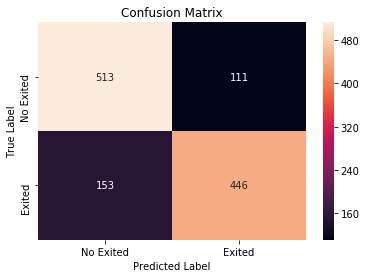

In [0]:
confusion_matrix_c(y_test, y_pred_rf)

In [0]:
rf_score_train = rf.score(X_train,y_train)
print("Train Prediction Score",rf_score_train*100)
rf_score_test = accuracy_score(y_test,y_pred_rf)
print("Test Prediction Score",rf_score_test*100)


Train Prediction Score 89.09154682567521
Test Prediction Score 78.41373671300082


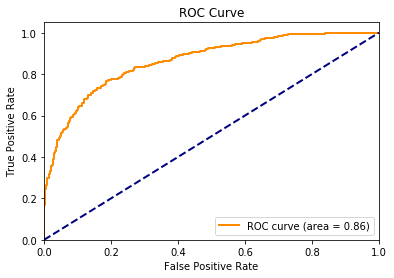

In [0]:
y_predict_probabilities = rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)

Random florest had a so better result than Decision tree, that was the best model until here. Its values of precision, recall and f1-score are good, and it had a great fail in mistakes about fake negatives if compared Decision tree.

### Gradient Boosting

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [0]:
param_grid={'max_depth':range(1,15,2),
            'n_estimators':[125,250],
           'min_child_weight':[1,3,6]}
xgb_g=XGBClassifier(random_state=42)
xgb_cv=GridSearchCV(xgb_g,param_grid,cv=10,scoring='accuracy',n_jobs=-1)
xgb_cv.fit(X_train,y_train)

print("Best parameters:",xgb_cv.best_params_)
print("Accuracy :",xgb_cv.best_score_)

Best parameters: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 125}
Accuracy : 0.777621887057173


In [0]:
xgbc = XGBClassifier(max_depth=3, min_child_weight=1, n_estimators=125, random_state=42)
xgbc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=125, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred_xgbc = dt.predict(X_test)

In [0]:
print(classification_report(y_test,y_pred_xgbc))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75       606
           1       0.76      0.71      0.74       617

    accuracy                           0.74      1223
   macro avg       0.75      0.74      0.74      1223
weighted avg       0.75      0.74      0.74      1223



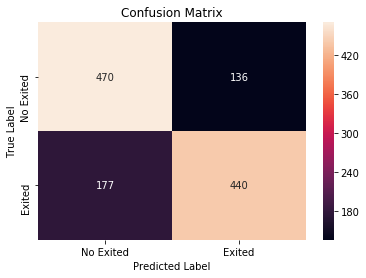

In [0]:
confusion_matrix_c(y_test, y_pred_xgbc)

In [0]:
xgbc_score_train = xgbc.score(X_train,y_train)
print("Train Prediction Score",xgbc_score_train*100)
xgbc_score_test = accuracy_score(y_test,y_pred_xgbc)
print("Test Prediction Score",xgbc_score_test*100)

Train Prediction Score 81.37495615573484
Test Prediction Score 74.40719542109566


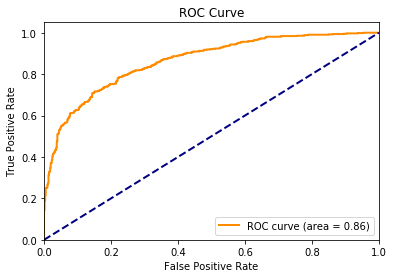

In [0]:
y_predict_probabilities = xgbc.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)

Gradient Boosting had a good result beetwen Decision tree and Randon florest.

If I stoped this analyse here, I would use Random Florest as model to build this solution.

## Deep Learning

After test so many possibilities, I still to try use a neural network to compare results.

In [0]:
X = dataset.drop(['Exited'],axis=1)
y = dataset['Exited']

In [0]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [0]:
from keras import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [0]:
classifier = Sequential()

n_cols = X_train.shape[1]

classifier.add(Dense(50, activation = "relu", input_shape=(n_cols,)))
classifier.add(Dropout(0.3, noise_shape=None, seed=None))
classifier.add(Dense(50, activation = "relu"))
classifier.add(Dropout(0.2, noise_shape=None, seed=None))
classifier.add(Dense(50, activation = "relu"))
classifier.add(Dense(1, activation = "sigmoid"))
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 50)                550       
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 51        
Total params: 5,701
Trainable params: 5,701
Non-trainable params: 0
_________________________________________________________________


In [0]:
classifier.compile(optimizer ='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [0]:
classifier.fit(X_train,y_train, batch_size=10, epochs=100)

Epoch 1/100
2851/2851 [==============================] - 2s 864us/step - loss: 0.6506 - acc: 0.6128
Epoch 2/100
2851/2851 [==============================] - 1s 187us/step - loss: 0.5825 - acc: 0.7047
Epoch 3/100
2851/2851 [==============================] - 1s 185us/step - loss: 0.5610 - acc: 0.7194
Epoch 4/100
2851/2851 [==============================] - 1s 182us/step - loss: 0.5432 - acc: 0.7247
Epoch 5/100
2851/2851 [==============================] - 1s 176us/step - loss: 0.5155 - acc: 0.7478
Epoch 6/100
2851/2851 [==============================] - 1s 180us/step - loss: 0.5110 - acc: 0.7429
Epoch 7/100
2851/2851 [==============================] - 1s 178us/step - loss: 0.4955 - acc: 0.7510
Epoch 8/100
2851/2851 [==============================] - 1s 179us/step - loss: 0.4991 - acc: 0.7604
Epoch 9/100
2851/2851 [==============================] - 1s 190us/step - loss: 0.4879 - acc: 0.7650
Epoch 10/100
2851/2851 [==============================] - 1s 187us/step - loss: 0.4915 - acc: 0.7608

In [0]:
eval_model = classifier.evaluate(X_train, y_train)
eval_model

2851/2851 [==============================] - 1s 295us/step


[0.3563414437651258, 0.8326902841212915]

In [0]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred>0.5)

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       630
           1       0.78      0.76      0.77       593

    accuracy                           0.78      1223
   macro avg       0.78      0.78      0.78      1223
weighted avg       0.78      0.78      0.78      1223



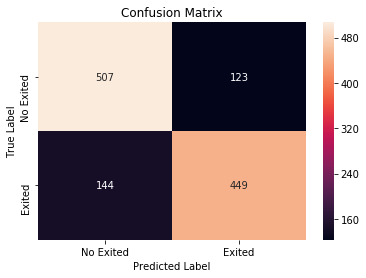

In [0]:
confusion_matrix_c(y_test, y_pred)

The neural network got it the best result, closer to Radom Florest, but superior, even simple, with few layers. And for this is my choice. Because this neural network still has potential to improve with changes in its layers. The random forest has reached the limit of this scenario, with these data, under these conditions.

I know that we are often tempted to use the neural network as a solution to everything and this is not true. Neural network requires more computer performance, and if performance were a problem, I would rather use random forest as a solution. But as this not a question, if yes the best result, I choose the neural network.

# Conclusion

In my opinion I got it a good test, not only exactly for the result, the accuracy wasn't many high, but also for all process until to arrive the final solution.

I did my best inside my possibilities. I run each model with a lot ways to get a better solution. 
I did a microservice with the choosed solution because I was easy to do, it isn't   necessary, but I thought if I can do I will do. 

However, yes, somethings could be better.
About data, I could have done a residue analysis to identify the best features. He could have made a PCA to see if he would get a better result.
I could have tried to generate more data based on the clients in churn to see if with a larger dataset the result would be more assertive or use all dataset applying penalty.
About models I could have tested a pipeline as ensemble with the best algorithms, I could have run with a PCA compacting the data. I could have tried more possibilities in layers of neural network.
in microservice I used REST, but I left a structure ready to show more than one possibility of access, and could have done an example call via GraphQL using Flask with Graphene.
